# Decoding position from firing rates 

In this example we show how position can be decoded from neural firing rates. 
We use a Naive Bayes decoder. For this you will use (very simply) sklearn's linear regression model. 

The plan is as follows. 
1. Initialise a 2D `Environment` an `Agent` and some populations of various types of `Neurons` 
1. Explore the environment for 10 minutes, then train decoders to map firing rates to positions from the "training" data generates.
1. Explore for 1 extra minute. Decode position from this "testing" data. Compare to the true position.


In [114]:
from ratinabox import *
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import PlaceCells,GridCells,BoundaryVectorCells

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge

First make a function `train_decoder()` which takes in a population of `Neurons` and trains a Naive Bayes decoder on data stored in its history data frame. This decoder is saved into the population class as an attribute. 

A second function `decode_position()` takes a population of `Neurons` and decodes position from firing rate data in tis history data frame and the decoder just trained. 

In [115]:
def train_decoder(Neurons,t_start=None,t_end=None):
    """t_start and t_end allow you to pick the poritions of the saved data to train on."""
    #Get training data
    t = np.array(Neurons.history['t'])
    if t_start is None: i_start = 0
    else: i_start = np.argmin(np.abs(t-t_start))
    if t_end is None: i_end = -1
    else: i_end = np.argmin(np.abs(t-t_end))
    t = t[i_start:i_end]
    fr = np.array(Neurons.history['firingrate'])[i_start:i_end]
    pos = np.array(Neurons.Agent.history['pos'])[i_start:i_end]
    #Initialise and fit model
    model = Ridge(alpha=0.01)
    model.fit(fr,pos)    
    #Save model into Neurons class for later use
    Neurons.decoding_model = model
    return model

def decode_position(Neurons,t_start=None,t_end=None):
    """t_start and t_end allow you to pick the poritions of the saved data to train on.
    Returns a list of times and decoded positions"""
    #Get testing data
    t = np.array(Neurons.history['t'])
    if t_start is None: i_start = 0
    else: i_start = np.argmin(np.abs(t-t_start))
    if t_end is None: i_end = -1
    else: i_end = np.argmin(np.abs(t-t_end))
    t = t[i_start:i_end]
    fr = np.array(Neurons.history['firingrate'])[i_start:i_end]
    #decode position from the data and using the decoder saved in the  Neurons class 
    decoder = Neurons.decoding_model
    decoded_position = decoder.predict(fr)
    return (t, decoded_position)

Initialise Environment, Agent, and cell populations. We will compare place cells, grid cells and boundary vectory cells. 

In [116]:
Env = Environment()
Ag = Agent(Env)
Ag.dt = 50e-3

PCs = PlaceCells(Ag,params={'n':50,'color':'C1'})
GCs = GridCells(Ag,params={'n':50,'color':'C2','gridscale':0.7},)
BVCs = BoundaryVectorCells(Ag,params={'n':50,'color':'C3'})

Generate training data (5 minutes of random exploration)...

(<Figure size 1080x216 with 5 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

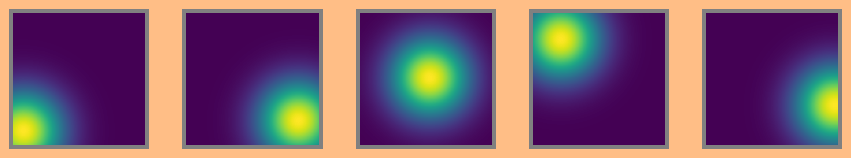

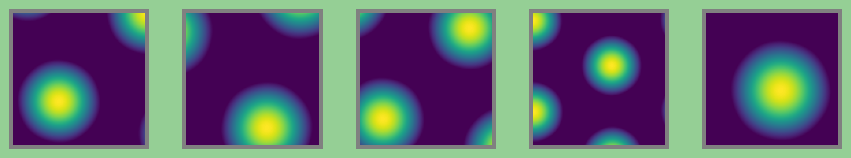

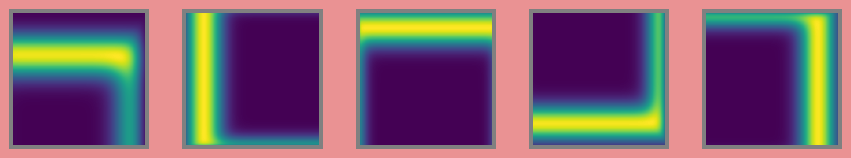

In [117]:
PCs.plot_rate_map(chosen_neurons='5')
GCs.plot_rate_map(chosen_neurons='5')
BVCs.plot_rate_map(chosen_neurons='5')

In [118]:
from tqdm import tqdm 
for i in tqdm(range(int(5*60/Ag.dt))):
    Ag.update()
    PCs.update()
    GCs.update()
    BVCs.update()

100%|██████████| 6000/6000 [00:10<00:00, 562.75it/s]


...and train decoder models.

In [119]:
train_decoder(PCs)
train_decoder(GCs)
train_decoder(BVCs)

Ridge(alpha=0.01)

Now generate an additional minute of testing data and "decode" position from it.

In [124]:
for i in tqdm(range(int(60/Ag.dt))):
    Ag.update()
    PCs.update()
    GCs.update()
    BVCs.update()

t, pos_PCs = decode_position(PCs,t_start=Ag.t-60)
t, pos_GCs = decode_position(GCs,t_start=Ag.t-60)
t, pos_BVCs = decode_position(BVCs,t_start=Ag.t-60)

100%|██████████| 1200/1200 [00:02<00:00, 558.27it/s]


Visualise results: blue is the ground truth (real position) whereas coloured traces are the decodings.

Text(0.5, 1.0, 'Boundary vector cells')

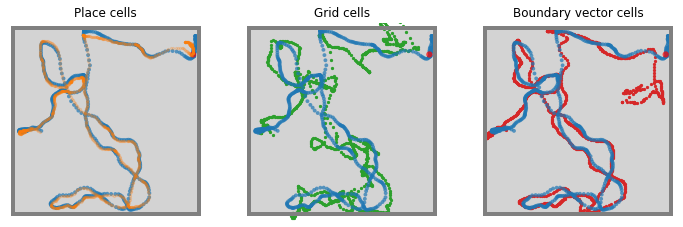

In [125]:

fig, ax = plt.subplots(1,3,figsize=(12,4))
Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[0])
ax[0].scatter(pos_PCs[:,0],pos_PCs[:,1],s=5,c='C1',alpha=0.2,zorder=3.1)
ax[0].set_title("Place cells")

Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[1])
ax[1].scatter(pos_GCs[:,0],pos_GCs[:,1],s=5,c='C2',alpha=1)
ax[1].set_title("Grid cells")

Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[2])
ax[2].scatter(pos_BVCs[:,0],pos_BVCs[:,1],s=5,c='C3',alpha=1)
ax[2].set_title("Boundary vector cells")
